---
title: "Light Measurement Analysis"
execute:
  echo: false
  output: false
---



In [1]:
#Import packages
import pandas as pd
import glob
import numpy as np
import pytz as pt
from pytz import timezone
import datetime
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform
import ephem
import seaborn as sns
from scipy.integrate import simps

In [2]:
#Load Data

#This code block needs to be updated to pull data from OSN once the data has been uploaded on to OSN.

def loadData(path):
    df=pd.read_csv(path,parse_dates=['dateTime'])
    df=df.set_index(['dateTime'])
    #df = df.resample('10S').mean()
    df.dropna(how='any', inplace=True)
    df.index = df.index.tz_localize(timezone('UTC')).tz_convert(timezone('US/Central'))
    df = df.div(df.max())
    return df



In [3]:
#| echo: true
#| output: true

# read irradiance data from url for Jan 2nd
#light_url = "https://ncsa.osn.xsede.org/ees230012-bucket01/central-node-8/2023/2023/05/02/MINTS_2cf7f12032305202_AS7526X_2023_01_02.csv"
#df_light = loadData(light_url)
df_light = loadData('testfile.csv') 
df_light.head()

,channelA410nm,channelB435nm,channelC460nm,channelD485nm,channelE510nm,channelF535nm,channelG560nm,channelH585nm,channelR610nm,channelI645nm,channelS680nm,channelJ705nm,channelT730nm,channelU760nm,channelV810nm,channelW860nm,channelK900nm,channelL940nm
dateTime,,,,,,,,,,,,,,,,,,
2023-01-02 03:03:31.789923-06:00,0.014842,0.004237,0.007014,0.003713,0.003168,0.005187,3.020314e-08,3.281136e-08,0.004614,0.083056,0.002116,0.035227,0.001104,0.001116,0.001209,0.001623,0.021448,0.028037
2023-01-02 03:04:44.797683-06:00,0.014842,0.004237,0.007014,0.003713,0.003168,0.005187,3.020314e-08,3.281136e-08,0.004614,0.084164,0.002116,0.035227,0.001104,0.001116,0.001209,0.001623,0.021448,0.028037
2023-01-02 03:07:10.802676-06:00,0.014842,0.004237,0.007014,0.003713,0.003168,0.005187,3.020314e-08,3.290901e-08,0.004614,0.083056,0.002116,0.035227,0.001104,0.001116,0.001209,0.001623,0.021448,0.028037
2023-01-02 03:08:23.797607-06:00,0.014842,0.004237,0.007014,0.003713,0.003168,0.005187,3.030415e-08,3.290901e-08,0.004614,0.083056,0.002116,0.035227,0.001104,0.001116,0.001209,0.001623,0.021448,0.028037
2023-01-02 03:09:36.850158-06:00,0.014842,0.004237,0.007014,0.003713,0.003168,0.005187,3.020314e-08,3.281136e-08,0.004614,0.083056,0.002116,0.035227,0.001104,0.001116,0.001209,0.001623,0.021448,0.028037


In [4]:
# Create the color palette for the wavelength ranges

def wavelength_to_rgb(wavelength, gamma=0.8):
    
    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 750:
        A = 1.
    else:
        A=0.5
    if wavelength < 380:
        wavelength = 380.
    if wavelength >750:
        wavelength = 750.
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    return (R,G,B,A)


wavelengths = [410, 435, 460, 485,
       510, 535, 560, 585,
       610, 645, 680, 705,
       730, 760, 810, 860,
       900, 940]
colors = [wavelength_to_rgb(wavelength) for wavelength in wavelengths]
   

In [5]:
# Calculate sunrise and sunset times for the specific day

#Change this to get the lat long coordinates from the GPS sensor data
latitude = 32.9857  
longitude = -96.7502

date=df_light.index.date[0] 
date_name=date.strftime('%Y/%m/%d') 
observer = ephem.Observer()
observer.lat = str(latitude)
observer.lon = str(longitude)
observer.date = date
sunrise_time = ephem.localtime(observer.previous_rising(ephem.Sun())).time()
sunset_time = ephem.localtime(observer.next_setting(ephem.Sun())).time()


sunrise_timestamp_str = sunrise_time.strftime('%H:%M:%S')
sunset_timestamp_str = sunset_time.strftime('%H:%M:%S')

sunrise_timestamp = pd.Timestamp.combine(date, sunrise_time)
sunset_timestamp = pd.Timestamp.combine(date, sunset_time)

sunrise_timestamps=pd.to_datetime(sunrise_timestamp).tz_localize(timezone('US/Central'))
sunset_timestamps=pd.to_datetime(sunset_timestamp).tz_localize(timezone('US/Central'))


In [6]:
#Calculate the total irradiance from the spectrally resolved components

total_irradiance = np.zeros(len(df_light.index))

for i, row in enumerate(df_light.iterrows()):
    irradiance = row[1].values  
    total_irradiance[i] = simps(irradiance, wavelengths)  

df_light['Total Irradiance'] = total_irradiance

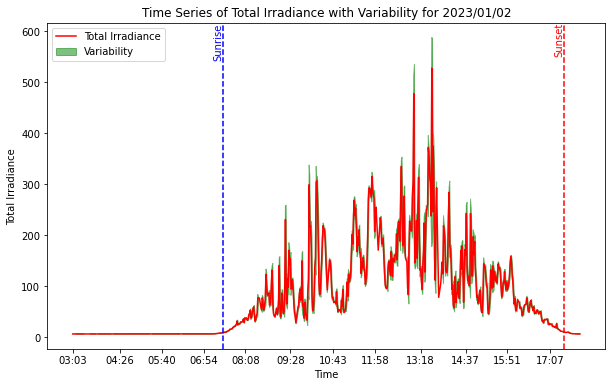

In [7]:
#| echo: false
#| output: true

#Time series with variability shading in the back

plt.figure(figsize=(10, 6))
plt.plot(df_light.index, df_light['Total Irradiance'], color='red', label='Total Irradiance')

rolling_mean = df_light['Total Irradiance'].rolling(window='120s').mean()
rolling_std = df_light['Total Irradiance'].rolling(window='120s').std()
upper_bound = rolling_mean + rolling_std
lower_bound = rolling_mean - rolling_std
plt.fill_between(df_light.index, lower_bound, upper_bound, color='green', alpha=0.5, label='Variability')

plt.xlabel('Time')
plt.ylabel('Total Irradiance')


hourly_ticks = df_light.index[::60]  
hourly_labels = [dt.strftime("%H:%M") for dt in hourly_ticks]
plt.xticks(hourly_ticks, hourly_labels)

plt.title(f"Time Series of Total Irradiance with Variability for {date_name}")
plt.legend()

plt.axvline(x=sunrise_timestamps, color='blue', linestyle='--', label='Sunrise')
plt.axvline(x=sunset_timestamps, color='red', linestyle='--', label='Sunset')
plt.text(sunrise_timestamps, plt.ylim()[1], 'Sunrise', rotation='vertical', color='blue', va='top', ha='right')
plt.text(sunset_timestamps, plt.ylim()[1], 'Sunset', rotation='vertical', color='red', va='top', ha='right')

plt.grid(False)
plt.show()


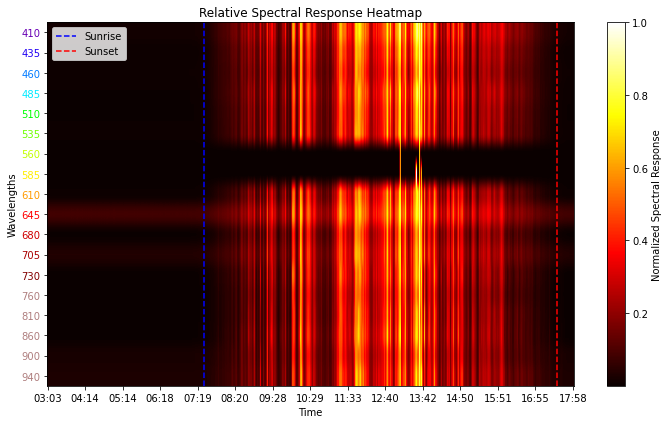

In [8]:
#| echo: false
#| output: true

# Spectral Response Heat Map


timestamps = df_light.index

plt.figure(figsize=(10, 6))
heatmap = plt.imshow(df_light.iloc[:, :-1].T, cmap='hot', aspect='auto')
plt.colorbar(heatmap, label='Normalized Spectral Response')
plt.xlabel('Time')
plt.ylabel('Wavelengths')
plt.title('Relative Spectral Response Heatmap')


x_ticks = range(0, len(timestamps), 50)  
x_labels = [timestamps[i].strftime('%H:%M') for i in x_ticks]
plt.xticks(x_ticks, x_labels)
y_labels = list(map(str, wavelengths))
plt.yticks(range(len(df_light.columns)-1), y_labels)
for i, label in enumerate(plt.gca().get_yticklabels()):
    label.set_color(colors[i % len(colors)])  



sunrise_value = np.argmin(np.abs(pd.to_datetime(timestamps).tz_localize(None) - sunrise_timestamp))
sunset_value = np.argmin(np.abs(pd.to_datetime(timestamps).tz_localize(None) - sunset_timestamp))


plt.axvline(x=sunrise_value, color='blue', linestyle='--', label='Sunrise')
plt.axvline(x=sunset_value, color='red', linestyle='--', label='Sunset')

plt.legend()

plt.grid(False)

plt.tight_layout()
plt.show()

In [9]:
#| echo: false
#| output: true

# Generate Text
print(f"The sunrise was at {sunrise_timestamp_str} AM")
print(f"The sunset was at {sunset_timestamp_str} PM")

The sunrise was at 07:29:37 AM
The sunset was at 17:32:20 PM
